# Classification. Linear models and KNN

In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"

    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.

        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init

    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""

        # linear combinations of weights and sample features
        # y = w_0 + w_1*x_1 + ... + w_n*x_n

        result = []
        for x in X:
            wx = np.sum(weights @ x)
            result.append(1 / (1 + np.exp(-wx)))
        return result

    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        N_samples = x.shape[0]
        n_features = x.shape[1]

        sum = 0
        for i in range(N_samples):
            wx = np.zeros(n_features)
            for j in range(1, n_features):
                wx += weights[j] * x[i][j]
            wx = np.sum(wx) + weights[0]
            sum += np.log(1 + np.exp(-(wx * y[i])))
        return sum / N_samples + np.linalg.norm(weights) / (2 * self.C)
        # return sum / N_samples + 1 / (2 * self.C) * (np.sum(weights) ** 2)

        # count = len(x)
        # l2norm = np.sum(weights ** 2) ** 0.5
        # wx = np.sum(x * weights[1:] + weights[0])
        # sum_log = np.sum(np.log(1 + np.exp(-1 * wx * y)))
        # reg_strength = 1 / (2 * self.C)
        # return sum_log / count + reg_strength * l2norm

    def fit(self, X, y):
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])  # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features)
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold,
                                                      size=num_features)  # random weight initialization
        N = X_ext.shape[0]
        self.loss_history = [self.get_loss(X, self.weights_, y)]
        for i in range(self.max_iter):
            delta_grad = np.zeros(num_features)
            for j in range(N):
                delta_grad += X_ext[j] * y[j] * (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext[j] * y[j]))))
            delta = self.weights_ / self.C - delta_grad / N
            self.weights_ -= self.eta * delta
            self.loss_history.append(self.get_loss(X, self.weights_, y))
            # wx = np.sum(X @ self.weights_[1:]) + self.weights_[0]
            # # wx = np.sum(X_ext @ self.weights_)
            # exp = 1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext.T @ y)))
            # exp = 1 - 1 / (1 + np.exp(-(np.sum(y*wx))))
            # delta = (y @ X_ext) * exp / len(y) - self.weights_ / self.C
            # self.weights_ += self.eta * delta
            # w(t+1)-w(t) = self.eta * delta
            if np.linalg.norm(self.eta * delta) < self.tol:
                break

    def predict_proba(self, X):
        """Predict positive class probabilities.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else:
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")

    def predict(self, X):
        """Predict classes.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return [1 if y >= 0.5 else -1 for y in self.predict_proba(X)]

In [5]:
print(list(range(10)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [6]:
from sklearn import datasets
from sklearn import metrics

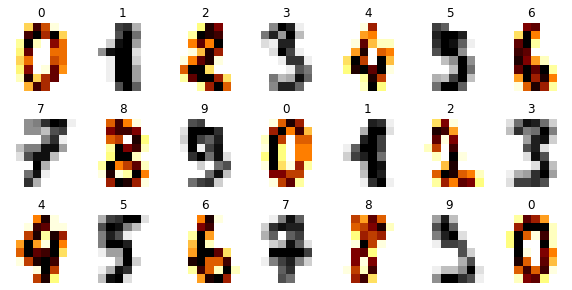

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()

    acc_train = metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train)
    acc_test = metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

    return acc_train, acc_test

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([3.1000e-06, 0.0000e+00, 4.1800e-05, 5.4770e-04, 2.2130e-04,
                                              4.8750e-04, 1.3577e-03, 5.9780e-04, 5.6400e-05, -7.0000e-07,
                                              1.6910e-04, 2.5190e-04, -4.3700e-04, 3.6190e-04, 1.0049e-03,
                                              4.2280e-04, 2.5700e-05, 3.0000e-07, -1.1500e-05, -7.2440e-04,
                                              -2.6200e-04, 8.7540e-04, 4.1540e-04, -8.4200e-05, -5.2000e-06,
                                              0.0000e+00, -2.2160e-04, -5.7130e-04, 9.8570e-04, 1.3507e-03,
                                              5.0210e-04, -1.7050e-04, -1.0000e-06, 0.0000e+00, -6.7810e-04,
                                              -1.0515e-03, -4.4500e-05, 3.7160e-04, 4.2100e-04, -8.1800e-05,
                                              0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
                                              1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
                                              -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
                                              -3.9560e-04, -1.7700e-05, -3.0000e-07, 2.6800e-05, 6.3920e-04,
                                              1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]),
                   atol=1e-5)

In [14]:
model = CustomLogisticRegression()

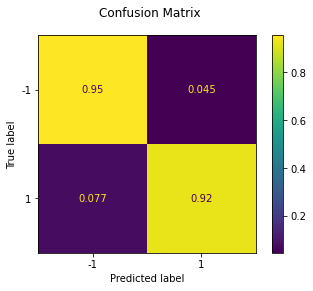

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

Text(0, 0.5, 'logloss')

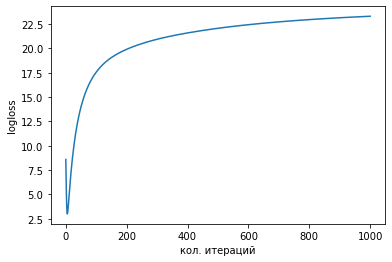

In [18]:
## your code
model = CustomLogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
sns.lineplot(data=model.loss_history)
plt.xlabel('кол. итераций')
plt.ylabel('logloss')

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

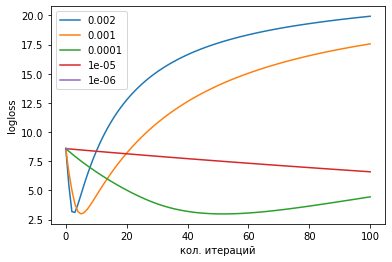

In [19]:
eta_variants = [0.002, 0.001, 0.000_1, 0.000_01, 0.000_001]
for eta in eta_variants:
    model = CustomLogisticRegression(eta=eta, max_iter=100)
    model.fit(X_train, y_train)
    sns.lineplot(data=model.loss_history)
    plt.legend(eta_variants)
    plt.xlabel('кол. итераций')
    plt.ylabel('logloss')

С уменьшением $\eta$ (learning rate) требуется больше количество итераций для того, чтобы достичь наименьшего значения logloss. При $\eta= 0.000001$ мы упираемся в параметр tol (Tolerance for stopping criteria)


**(0.5 points)** Try different regularization parameter values and compare the model quality.

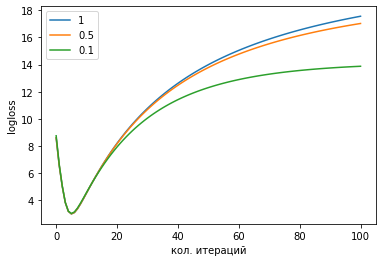

In [20]:
c_variants = [1, 0.5, 0.1]
for C in c_variants:
    model = CustomLogisticRegression(C=C, max_iter=100)
    model.fit(X_train, y_train)
    sns.lineplot(data=model.loss_history)
    plt.legend(c_variants)
    plt.xlabel('кол. итераций')
    plt.ylabel('logloss')

C: float, default=1.0
Inverse of regularization strength; must be a positive float.
Smaller values specify stronger regularization.

Часть формулы

$\eta \frac{1}{C} w,$

С увеличением силы регуляризация $C$ максимальное значение logloss уменьшается

**(0.5 points)** Compare zero initialization and random initialization. 

False 0.8643006263048016 0.8833333333333333 0.8810810810810811 0.8907103825136612
True 0.8636047320807237 0.8861111111111111 0.8817204301075269 0.8961748633879781


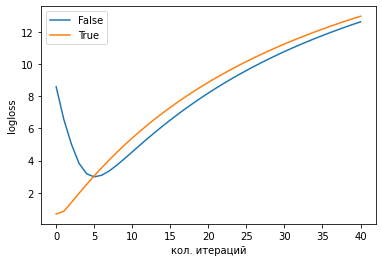

In [21]:
zero_variants = [False, True]
for zero_init_value in zero_variants:
    model = CustomLogisticRegression(zero_init=zero_init_value, max_iter=40)
    model.fit(X_train, y_train)
    acc_train = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train)
    acc_test = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    precision_test = metrics.precision_score(y_pred=model.predict(X_test), y_true=y_test)
    recall_test = metrics.recall_score(y_pred=model.predict(X_test), y_true=y_test)
    print(zero_init_value, acc_train, acc_test, precision_test, recall_test)

    sns.lineplot(data=model.loss_history)
    plt.legend(zero_variants)
    plt.xlabel('кол. итераций')
    plt.ylabel('logloss')

zero_init: bool, default=False Zero weight initialization.
При обнулённых инициализированных весах, logloss логарифмически растёт с единицы, при увеличении итераций. При случайном наборе начальных весов, можно увидеть оптимальное количество итераций при которых logloss минимален.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [22]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"

    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps

    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        n_samples = X.shape[0]
        k_samples = Y.shape[0]
        n_features = X.shape[1]
        if n_features != Y.shape[1]:
            raise Exception('Количество характеристик разное')

        p = []
        for n_sample in range(n_samples):
            p_row_y_for_x = []
            for k_sample in range(k_samples):
                d = np.linalg.norm(X[n_sample] - Y[k_sample])
                p_row_y_for_x.append(d)
            p.append(p_row_y_for_x)

        return np.array(p)

    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p = np.zeros(np.shape(model.classes_))
        classes = np.array(model.classes_)

        for y_index, class_name in enumerate(y):
            # np.add.at(p, y[y_index], weights[y_index])
            p[np.where(classes == class_name)[0][0]] += weights[y_index]
        return p

    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)

    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            distance = self.get_pairwise_distances(X, self.points)

            weights_of_points = np.ones(len(distance))
            if self.weights == 'distance':
                weights_of_points = 1 / (distance + self.eps)

            # norm_w_classes = self.get_class_weights(self.y, weights_of_points)

            n_samples = X.shape[0]
            n_classes = np.shape(model.classes_)[0]

            # print(norm_w_classes.shape)

            # norm_w_classes = self.get_class_weights(self.y, weights_of_points)

            # all_rows = np.arange(n_samples)
            # print(distance)
            # probabilities = []
            # _y = self.y.reshape((-1, 1))
            # for k, classes_k in enumerate(model.classes_):
            #     pred_labels = _y[:][self.n_neighbors]
            #     proba_k = np.zeros((n_samples, n_classes))
            #
            #     # a simple ':' index doesn't work right
            #     for i, idx in enumerate(pred_labels.T):  # loop is O(n_neighbors)
            #         proba_k[all_rows, idx] += weights_of_points[:, i]
            #
            #     # normalize 'votes' into real [0,1] probabilities
            #     normalizer = proba_k.sum(axis=1)[:, np.newaxis]
            #     normalizer[normalizer == 0.0] = 1.0
            #     proba_k /= normalizer
            #
            #     probabilities.append(proba_k)
            #
            # return probabilities

            # print(pd.DataFrame(weights_of_points))
            # probabilities = []
            #
            # # n_classes = np.shape(model.classes_)[0]
            # # # sum_w_by_class = self.get_class_weights(self.y, self.weights)
            # # for index_class in range(n_samples) :
            # #     probabilities_n = np.zeros(n_classes)
            # #     # probability = w / sum_w_by_class
            # #     # probability = w
            # #     probabilities.append(probabilities_n)
            # #
            # # return np.array(probabilities)

        else:
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")

    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [23]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
X, y = datasets.load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)))
model.predict_proba(X_test)
# print(model.predict_proba(X_test), knn.predict_proba(X_test))

In [24]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [25]:
assert np.allclose(model.get_pairwise_distances(np.array([[0, 1], [1, 1]]),
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.]]))

In [26]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])),
                   np.array([2, 4, 0]))

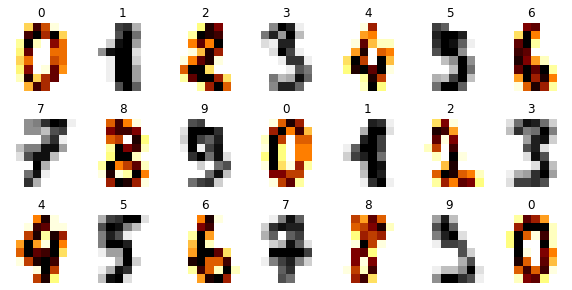

In [27]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [28]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [29]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

![](https://medialeaks.ru/wp-content/uploads/2020/03/1-1-12.jpg)

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

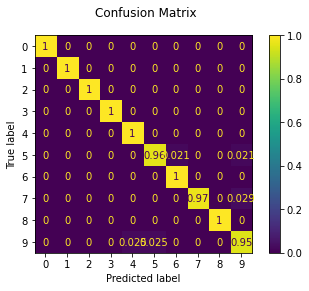

In [30]:
train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)

Можно наблюдать, что проблемы с определением значения числа возникает на цифрах 5, 7, 9.
- 9 похожа на 4 и 5
- 7 похожа на 9
- 5 похожа на 6 и 9

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

При значении K = 5


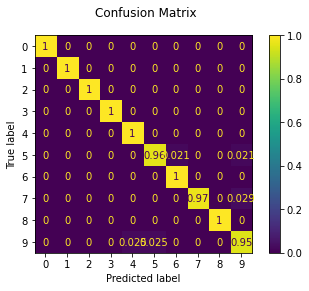

При значении K = 10


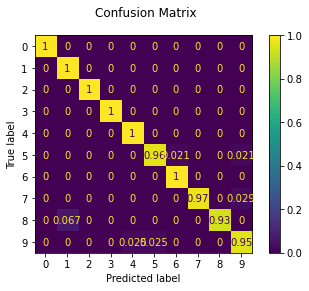

При значении K = 50


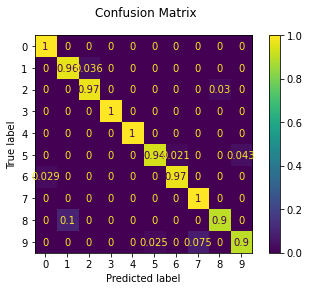

При значении K = 100


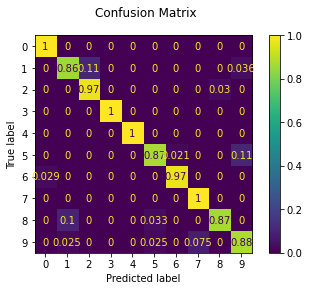

In [31]:
k_values = [5, 10, 50, 100]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    print('При значении K =', k)
    train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)

С увеличением параметра K появляются сложности с определением значений других цифр, которые вызывали трудности в прогнозе при k=5. И всё также наблюдаются проблемы у цифр 9, 7, 5, а при увеличении K шанс ошибиться с этими цифрами немного растёт.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

weights = uniform


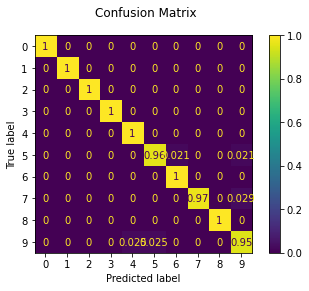

0.9895615866388309 0.9861111111111112
weights = distance


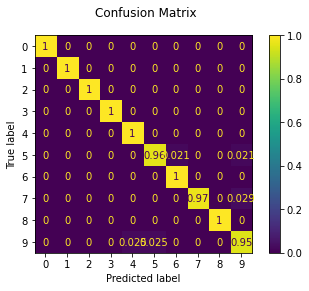

1.0 0.9861111111111112


In [32]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
print('weights = uniform')
train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)
print(train_acc, test_acc)

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
print('weights = distance')
train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)
print(train_acc, test_acc)

При weights = distance метрика Accuracy на тренировочных данных показывает идеальный результат, 100% угадывание, а при weights = uniform, метрика Accuracy на тренировочных данных показывает 99%
Значение weights = distance предпочтительнее, так как связи с соседями имеют веса, что по своей сути улучшает прогноз.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

На данный момент мы использовали функцию Эвклидового расстояния. Евклидово расстояние прекрасно работает, когда у вас маломерные данные, и величина векторов важна для измерения.
Но существуют и [другие функции](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric):
ManhattanDistance
ChebyshevDistance
MinkowskiDistance
WMinkowskiDistance
SEuclideanDistance
MahalanobisDistance

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Есть например Cosine Similarity.

![](https://miro.medium.com/max/433/0*WmZ-uk5VzfY7RiBt)

Оно часто используется в противовес эвклидового расстояния, так как не имеет проблем с высокой размерностью данных. Мы можем его например использовать в задачах анализа текста, когда данные представлены количеством слов. Например, когда слово встречается в одном документе чаще над другим, это не обязательно означает, что один документ больше связан с этим словом. Может случиться так, что документы имеют неравномерную длину, а величина подсчета имеет меньшее значение.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [33]:
PATH = "./data/"

In [34]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [35]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [36]:
print('Females', round(data.groupby(by='Sex').count().iloc[0, 1] / data.shape[0] * 100, 2), '%')
print('Males', round(data.groupby(by='Sex').count().iloc[1, 1] / data.shape[0] * 100, 2), '%')

Females 43.89 %
Males 56.11 %


In [37]:
stats_survived = data.groupby(by='Survived').Survived.count()
stats_survived = pd.DataFrame([['Погибло', stats_survived[0], stats_survived[0] / 100_000 * 100],
                               ['Выжило', stats_survived[1], stats_survived[1] / 100_000 * 100],
                               ['Итого', 100_000, 100]], columns=['', 'Количество', '%'])
stats_survived

,,Количество,%
0,Погибло,57226,57.226
1,Выжило,42774,42.774
2,Итого,100000,100.000


<AxesSubplot:title={'center':'Данные о погибших и выживших пассажиров'}, ylabel='Количество'>

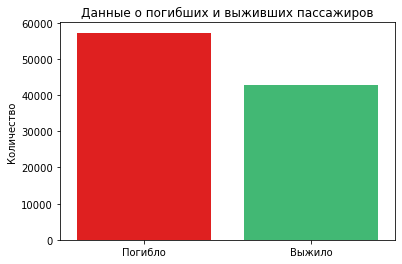

In [38]:
plt.title('Данные о погибших и выживших пассажиров')
sns.barplot(x=stats_survived.iloc[:2, 0], y=stats_survived.iloc[:2, 1], palette=["r", "#2ecc71"])

[Text(0.5, 0, 'ПОГИБЛО - ВЫЖИЛО'), Text(0, 0.5, 'Количество')]

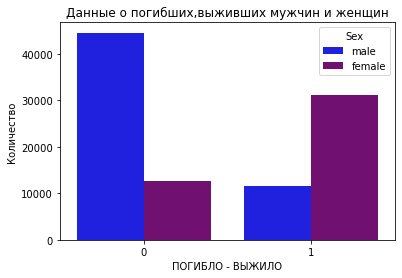

In [39]:
plt.title('Данные о погибших,выживших мужчин и женщин')
sns.countplot(data=data, x='Survived', hue="Sex", palette=["blue", "purple"]).set(xlabel="ПОГИБЛО - ВЫЖИЛО",
                                                                                  ylabel="Количество")

In [40]:
fm = pd.get_dummies(data.Sex)
newdata = pd.concat((fm, data), axis=1)
newdata
newdata = newdata.drop(["male"], axis=1)
newdata = newdata.rename(columns={"female": "Gender"})
newdata

,Gender,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,,
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,0,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


In [41]:
feature_lst = ['Gender', 'Survived']
corr = newdata[feature_lst].corr()
print("Коэффициент Пирсона", round(newdata[feature_lst].corr(method='pearson').iloc[1, 0], 2))

Коэффициент Пирсона 0.51


Незначительная связь между Полом и Выживанием существует.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

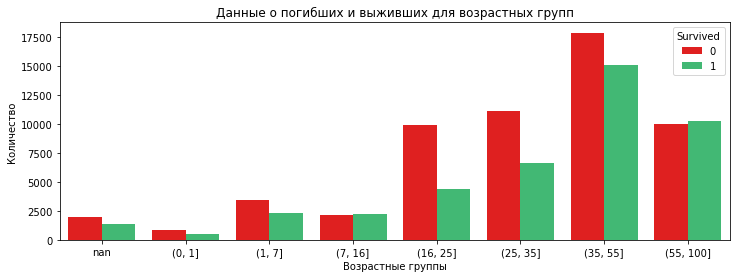

In [42]:
data['Age_Range'] = pd.cut(data.Age, [0, 1, 7, 16, 25, 35, 55, 100])
data['Age_Range'] = data.Age_Range.astype('str')
data['Age_Range'] = data.Age_Range.fillna('nan')

plt.figure(figsize=(12, 4))
plt.title('Данные о погибших и выживших для возрастных групп')
age_order = ['nan', '(0, 1]', '(1, 7]', '(7, 16]', '(16, 25]', '(25, 35]', '(35, 55]', '(55, 100]']
sns.countplot(data=data, x='Age_Range', hue="Survived", order=age_order, palette=["r", "#2ecc71"]).set(
    xlabel="Возрастные группы", ylabel="Количество")
plt.show()

In [43]:
data.groupby(by=['Survived']).Age.mean()

Survived
0    36.708695
1    40.553799
Name: Age, dtype: float64

In [44]:
data.groupby(by=['Survived']).Age.median()

Survived
0    36.0
1    43.0
Name: Age, dtype: float64

Выделяются возрастные группы в границах 16 лет до 35 лет, а также младенцы до 1 года - почти в 2 раза больше погибших пассажиров этих возрастов, чем выживших. Им менее повезло чем остальным, остальные же пассажиры (в возрасте от 1 года до 16 и старше 35 лет) имели по статистике почти равный шанс как спастись, так и погибнуть.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [45]:
data.Embarked.value_counts()

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64

Три уникальных порта. Данные указаны верно. C = Шербуре (Cherbourg), Q = Квинстаун (Queenstown), S = Саутгемптоне (Southampton)

In [46]:
data.Pclass.value_counts().index

Int64Index([3, 1, 2], dtype='int64')

Данные по Pclass содержат только значения 1,2,3 - что полностью совпадает с классами кают. Данные корректные.

In [47]:
class_data = data.groupby('Pclass').Survived.agg(['count', 'sum'])
class_data['Survived_ratio'] = round(class_data['sum'] / class_data['count'] * 100)
class_data

,count,sum,Survived_ratio
Pclass,,,
1,30315,17576,58.0
2,28679,15057,53.0
3,41006,10141,25.0


Люди из высших классов имели больше шансов выжить. 58% людей из высшего класса, 53% людей из среднего класса и только 25% процентов людей из низшего класса выжили.

In [48]:
embarked_survival_data = data.groupby('Embarked').Survived.agg(['count', 'sum'])
embarked_survival_data['survival_ratio'] = round(embarked_survival_data['sum'] / embarked_survival_data['count'] * 100)
embarked_survival_data

,count,sum,survival_ratio
Embarked,,,
C,22187,16669,75.0
Q,5424,3238,60.0
S,72139,22745,32.0


Пассажиры, что ступили на борт в порту Саутгемптоне имели шанс на выживание всего 32%. В других портах шанс погибнуть был меньше, шанса выжить.

На диаграмах ниже можно визуально наблюдать эти же сведения.

<AxesSubplot:xlabel='Survived', ylabel='Pclass'>

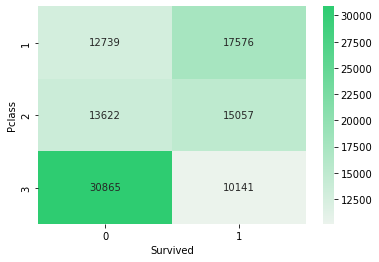

In [49]:
group = data.groupby(['Pclass', 'Survived'])
pclass_survived = group.size().unstack()

sns.heatmap(pclass_survived, annot=True, fmt="d", cmap=sns.light_palette("#2ecc71", as_cmap=True))

<AxesSubplot:xlabel='Survived', ylabel='Embarked'>

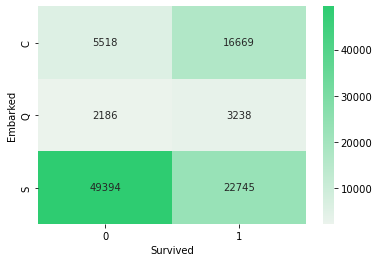

In [50]:
group = data.groupby(['Embarked', 'Survived'])
pclass_survived = group.size().unstack()

sns.heatmap(pclass_survived, annot=True, fmt="d", cmap=sns.light_palette("#2ecc71", as_cmap=True))

<AxesSubplot:xlabel='Sex', ylabel='Embarked'>

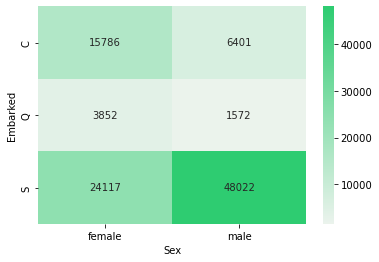

In [51]:
group = data.groupby(['Embarked', 'Sex'])
pclass_survived = group.size().unstack()

sns.heatmap(pclass_survived, annot=True, fmt="d", cmap=sns.light_palette("#2ecc71", as_cmap=True))

In [52]:
data.Fare.describe()

count    99866.00000
mean        43.92933
std         69.58882
min          0.68000
25%         10.04000
50%         24.46000
75%         33.50000
max        744.66000
Name: Fare, dtype: float64

In [53]:
(data.Fare.median(), data.Fare.mean())

(24.46, 43.92933040273962)

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [54]:
print('Процент пропущенных значений:\n', round(data.isnull().sum() / data.shape[0] * 100, 5))

Процент пропущенных значений:
 Survived      0.000
Pclass        0.000
Name          0.000
Sex           0.000
Age           3.292
SibSp         0.000
Parch         0.000
Ticket        4.623
Fare          0.134
Cabin        67.866
Embarked      0.250
Age_Range     0.000
dtype: float64


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Можно использовать dropna(), через loc. Например, работаем с возрастом и тарифом ( Age и Fare) и исследуем выживание , то код мог выглядеть так
`data.loc[:, ['Survived', 'Fare', 'Age']].dropna()`
Также можно попробовать заменить Null значения, на другие, подходящие по смыслу и ожиданиям. Делается это с помощью pandas.DataFrame.fillna

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Подготовим данные

План:
- Атрибут Sex переделываем в Gender. 1 - жен. 0 - муж.
- Embarked может быть Null. Не исключено, что такой объект может быть в тестовых данных, по которым нам предстоит дать прогноз, о том выжил или не выжил пассажир. Т.е. удалять такой объект нельзя. При исследовании мы видели, что больше всего село в порту S и погибших среди других портов тоже тут больше. Если это женщина, то скорее всего она выжила и села в порту S или Q, если мужчина, то погиб и вероятнее всего сел в порту S. Попробуем поставить всем пассажирам Embarked = S, если это мужчина, а если женщина - среднее между Q и S, там где значение Null.
- Embarked C, Q, S переделаем в 1, 2, 3
- 3% нулевых значений по Age. Меняем на ~значение медианы (Возраст 39 лет).
- Нулевые Fare поменяем на ~значение медианы

Остановимся пока на этом. Конечно можно усовершенствовать наши данные и дальше, но для этого нужно производить доп. исследования.

In [56]:
def prep_data(data: pd.DataFrame, return_y=True):
    work_data = data.copy()

    work_data.Sex = np.where(work_data.Sex == 'male', 0, 1)

    work_data.Embarked = np.where((work_data.Embarked.isnull()) & (work_data.Sex == 0), 0.35, work_data.Embarked)
    work_data.Embarked = np.where((work_data.Embarked.isnull()) & (work_data.Sex == 1), 0.525, work_data.Embarked)
    work_data.Embarked = work_data.Embarked.replace(['S', 'C', 'Q', ], [0.3, 0.60, 0.75])

    work_data.Age = work_data.Age.fillna(10.0)

    work_data.Fare = work_data.Fare.fillna(24.5)

    work_data['Family'] = work_data.SibSp + work_data.Parch
    work_data['Alone'] = np.where(work_data['Family'] == 0, 1, 0)

    X = work_data.loc[:, ['Sex', 'Pclass', 'Embarked', 'Age', 'Fare', 'Family', 'Alone']]

    if return_y:
        Y = work_data.Survived
        return X, Y

    return X

In [57]:
X, Y = prep_data(data)

In [58]:
X

,Sex,Pclass,Embarked,Age,Fare,Family,Alone
PassengerId,,,,,,,
0,0,1,0.3,10.00,27.14,2,0
1,0,3,0.3,10.00,13.35,0,1
2,0,3,0.3,0.33,71.29,3,0
3,0,3,0.3,19.00,13.04,0,1
4,0,3,0.3,25.00,7.76,0,1
...,...,...,...,...,...,...,...
99995,1,2,0.6,62.00,14.86,0,1
99996,0,2,0.3,66.00,11.15,0,1
99997,0,3,0.3,37.00,9.95,0,1


In [59]:
print('Процент пропущенных значений:\n', round(X.isnull().sum() / X.shape[0] * 100, 5))

Процент пропущенных значений:
 Sex         0.0
Pclass      0.0
Embarked    0.0
Age         0.0
Fare        0.0
Family      0.0
Alone       0.0
dtype: float64


Создадим функцию, которая будет выводить текстовые сведения по [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [60]:
def describe_conf_matrix_results(confusion_matrix_results):
    tn, fp, fn, tp = confusion_matrix_results.ravel()
    print('Позитив - выжил, негатив - погиб')
    display(pd.DataFrame((
        ('выжил', 'выжил', 'TP', tp),
        ('погиб', 'выжил', 'FN', fn),
        ('погиб', 'погиб', 'TN', tn),
        ('выжил', 'погиб', 'FP', fp),
    ), columns=['УТВЕРЖДАЕМ', 'РЕАЛЬНОСТЬ', 'МЕТКА', 'КОЛИЧЕСТВО РАЗ']))
    print('Значение Accuracy составляет', (tp + tn) / (tp + tn + fp + fn))

Создадим функцию, которая будет выводить визуальные данные по Confusion Matrix

In [61]:
def confusion_matrix_display(confusion_matrix_results):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_results)
    disp.plot()
    plt.show()

Создадим две модели KNN и Logistic Regression. Посмотрим на результаты.

array([0.7502, 0.7376, 0.7378, 0.7468, 0.7439, 0.7334, 0.7357, 0.7389,
       0.7366, 0.7417])

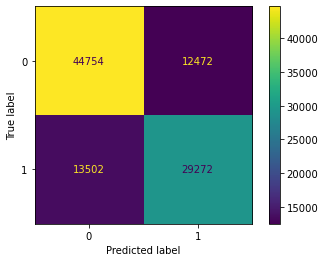

Позитив - выжил, негатив - погиб


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,выжил,выжил,TP,29272
1,погиб,выжил,FN,13502
2,погиб,погиб,TN,44754
3,выжил,погиб,FP,12472


Значение Accuracy составляет 0.74026


array([0.7665, 0.7568, 0.7519, 0.7569, 0.765 , 0.7572, 0.7535, 0.7593,
       0.7657, 0.7644])

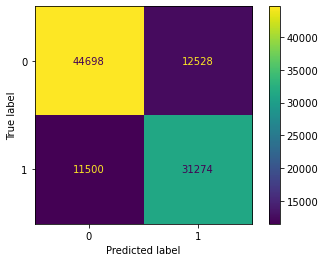

Позитив - выжил, негатив - погиб


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,выжил,выжил,TP,31274
1,погиб,выжил,FN,11500
2,погиб,погиб,TN,44698
3,выжил,погиб,FP,12528


Значение Accuracy составляет 0.75972


In [62]:
Input_norm = [
    ('standardScaler', StandardScaler()),
    ('knn', KNeighborsClassifier())]
pipeKnn = Pipeline(Input_norm)

Input_norm = [
    ('standardScaler', StandardScaler()),
    ('logreg', LogisticRegression())]
pipeLogreg = Pipeline(Input_norm)

kfold = KFold(n_splits=10, random_state=77, shuffle=True)

pipes = [
    pipeKnn,
    pipeLogreg,
]

for pipe in pipes:
    scores = cross_val_score(pipe, X, Y, cv=kfold)
    display(scores)
    y_pred = cross_val_predict(pipe, X, Y, cv=kfold)
    conf_mat = confusion_matrix(Y, y_pred)
    confusion_matrix_display(conf_mat)
    describe_conf_matrix_results(conf_mat)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

Модель LogisticRegression ведёт себя лучше, чем KNN. LogisticRegression определяет больше корректных выживших и меньше(на ~2000) ошибается, когда прогнозирует погибшего. Выбираем её. Посмотрим на результаты при разных параметрах LogisticRegression

In [63]:
for penalty in ['l1', 'l2']:
    for c in [1.0, 0.5]:
        print(penalty, c)
        Input_norm = [
            ('standardScaler', StandardScaler()),
            ('logreg', LogisticRegression(penalty=penalty, C=c, solver='liblinear', random_state=kfold.random_state))]
        pipeLogreg = Pipeline(Input_norm)
        y_pred = cross_val_predict(pipeLogreg, X, Y, cv=kfold)
        conf_mat = confusion_matrix(Y, y_pred)
        describe_conf_matrix_results(conf_mat)

l1 1.0
Позитив - выжил, негатив - погиб


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,выжил,выжил,TP,31274
1,погиб,выжил,FN,11500
2,погиб,погиб,TN,44699
3,выжил,погиб,FP,12527


Значение Accuracy составляет 0.75973
l1 0.5
Позитив - выжил, негатив - погиб


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,выжил,выжил,TP,31275
1,погиб,выжил,FN,11499
2,погиб,погиб,TN,44698
3,выжил,погиб,FP,12528


Значение Accuracy составляет 0.75973
l2 1.0
Позитив - выжил, негатив - погиб


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,выжил,выжил,TP,31275
1,погиб,выжил,FN,11499
2,погиб,погиб,TN,44698
3,выжил,погиб,FP,12528


Значение Accuracy составляет 0.75973
l2 0.5
Позитив - выжил, негатив - погиб


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,выжил,выжил,TP,31276
1,погиб,выжил,FN,11498
2,погиб,погиб,TN,44698
3,выжил,погиб,FP,12528


Значение Accuracy составляет 0.75974


Из вышеуказанных результатов L2 и С=0.5 выглядят лучше остальных. Посмотрим на max_iter

In [64]:
for with_std in [True, False]:
    print(with_std)
    Input_norm = [
        ('standardScaler', StandardScaler(with_std=True,with_mean=with_std)),
        ('logreg', LogisticRegression(penalty='l2', C=1, solver='liblinear', random_state=kfold.random_state))]
    pipeLogreg = Pipeline(Input_norm)
    y_pred = cross_val_predict(pipeLogreg, X, Y, cv=kfold)
    conf_mat = confusion_matrix(Y, y_pred)
    describe_conf_matrix_results(conf_mat)

True
Позитив - выжил, негатив - погиб


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,выжил,выжил,TP,31275
1,погиб,выжил,FN,11499
2,погиб,погиб,TN,44698
3,выжил,погиб,FP,12528


Значение Accuracy составляет 0.75973
False
Позитив - выжил, негатив - погиб


,УТВЕРЖДАЕМ,РЕАЛЬНОСТЬ,МЕТКА,КОЛИЧЕСТВО РАЗ
0,выжил,выжил,TP,31273
1,погиб,выжил,FN,11501
2,погиб,погиб,TN,44696
3,выжил,погиб,FP,12530


Значение Accuracy составляет 0.75969


In [65]:
pipeLogreg.fit(X, Y)

Pipeline(steps=[('standardScaler', StandardScaler(with_mean=False)),
                ('logreg',
                 LogisticRegression(C=1, random_state=77, solver='liblinear'))])

In [66]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [67]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [68]:
X_test = prep_data(test_data, False)

In [69]:
Y_pred_test = pipeLogreg.predict(X_test)

In [70]:
results = pd.DataFrame({'Survived': Y_pred_test.astype('int64')}, index=test_data.index)

In [71]:
results.to_csv(os.path.join(PATH, 'titanic', 'submission.csv'))

[Результаты score на kaggle](https://github.com/githubjeka/ml-intro/blob/main/tmp/Screenshot_2.png)